# 尝试加入动量  

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from network import Network
from solver import train, test
from plot import plot_loss_and_acc

## 读入MNIST数据集

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
def decode_image(image):
    # 归一化处理
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [784])
    image = image / 255.0
    image = image - tf.reduce_mean(image)
    return image

def decode_label(label):
    # 将标签变为one-hot编码
    return tf.one_hot(label, depth=10)

In [4]:
# 数据预处理
x_train = tf.data.Dataset.from_tensor_slices(x_train).map(decode_image)
y_train = tf.data.Dataset.from_tensor_slices(y_train).map(decode_label)
data_train = tf.data.Dataset.zip((x_train, y_train))

x_test = tf.data.Dataset.from_tensor_slices(x_test).map(decode_image)
y_test = tf.data.Dataset.from_tensor_slices(y_test).map(decode_label)
data_test = tf.data.Dataset.zip((x_test, y_test))

In [1]:
import time
from criterion import EuclideanLossLayer,SoftmaxCrossEntropyLossLayer
from optimizer import SGD
from layers import FCLayer, SigmoidLayer, ReLULayer

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
exec_result = pd.DataFrame(columns=['mode','batch_size','learning_rate_SGD', 'momentum','weight_decay','time','loss_validate','acc_validate'])

max_epoch = 20
disp_freq = 50
init_std = 0.01

In [6]:
batch_size = 100
learning_rate_SGD = 0.001
weight_decay = 0.1

for momentum in [0, 0.1, 0.55, 0.9, 0.99]:
    #Euclidean+Sigmoid
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]   

    #Euclidean+ReLU
    criterion = EuclideanLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    reluMLP = Network()
    # 使用FCLayer和ReLULayer构建多层感知机
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['Euclidean_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]     

    #CrossEntropy+Sigmoid
    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    t1=time.time()
    sigmoidMLP = Network()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    sigmoidMLP.add(FCLayer(784, 128))
    sigmoidMLP.add(SigmoidLayer())
    sigmoidMLP.add(FCLayer(128, 10))
    sigmoidMLP, sigmoid_loss, sigmoid_acc = train(sigmoidMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_Sigmoid',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,sigmoid_loss, sigmoid_acc]         

    criterion = SoftmaxCrossEntropyLossLayer()
    sgd = SGD(learning_rate_SGD, weight_decay,momentum)
    #CrossEntropy+ReLU
    reluMLP = Network()
    t1=time.time()
    # 使用FCLayer和SigmoidLayer构建多层感知机
    # 128为隐含层的神经元数目
    reluMLP.add(FCLayer(784, 128))
    reluMLP.add(ReLULayer())
    reluMLP.add(FCLayer(128, 10))
    reluMLP, relu_loss, relu_acc = train(reluMLP, criterion, sgd, data_train, max_epoch, batch_size, disp_freq)
    t2=time.time()
    exec_result.loc[exec_result.shape[0]] = ['CrossEntropy_ReLU',batch_size, learning_rate_SGD, momentum, weight_decay, t2-t1,relu_loss, relu_acc]      

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Epoch [0][20]	 Batch [0][550]	 Training Loss 5.0869	 Accuracy 0.0800
Epoch [0][20]	 Batch [50][550]	 Training Loss 1.8104	 Accuracy 0.0798
Epoch [0][20]	 Batch [100][550]	 Training Loss 1.2760	 A

In [7]:
exec_result['acc_validate_float'] = exec_result['acc_validate'].map(lambda x: np.average(x))
exec_result

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,100,0.001,0.00,0.1,42.074909,"[0.5193544682084369, 0.4167396770427404, 0.364...","[0.2218, 0.4354, 0.5536, 0.6236, 0.66980000000...",0.72049
1,Euclidean_ReLU,100,0.001,0.00,0.1,41.935513,"[0.6066053231156066, 0.43967822092945325, 0.36...","[0.4478000000000001, 0.573, 0.6629999999999999...",0.80681
2,CrossEntropy_Sigmoid,100,0.001,0.00,0.1,42.384914,"[2.2419760239290825, 2.120830066790953, 2.0448...","[0.2084, 0.34559999999999996, 0.50940000000000...",0.66653
3,CrossEntropy_ReLU,100,0.001,0.00,0.1,52.771345,"[1.7287515334418808, 1.316340443397868, 1.0911...","[0.5094, 0.7232000000000001, 0.796399999999999...",0.85185
4,Euclidean_Sigmoid,100,0.001,0.10,0.1,43.192641,"[0.46882086734492245, 0.3824436766165054, 0.33...","[0.3148, 0.5144, 0.6312, 0.6958, 0.7334, 0.764...",0.75270
5,Euclidean_ReLU,100,0.001,0.10,0.1,46.562965,"[0.6284309608096394, 0.43873470187546787, 0.35...","[0.39699999999999996, 0.5608, 0.66060000000000...",0.80322
6,CrossEntropy_Sigmoid,100,0.001,0.10,0.1,85.173177,"[2.2142067795608527, 2.110336441159032, 2.0385...","[0.24719999999999998, 0.45199999999999996, 0.5...",0.67096
7,CrossEntropy_ReLU,100,0.001,0.10,0.1,63.942119,"[1.660839475040853, 1.3178145956194982, 1.1201...","[0.54, 0.7057999999999999, 0.7761999999999999,...",0.84501
8,Euclidean_Sigmoid,100,0.001,0.55,0.1,56.571428,"[0.41495263560142653, 0.3354805097896369, 0.30...","[0.38800000000000007, 0.6302, 0.727, 0.7676, 0...",0.76113
9,Euclidean_ReLU,100,0.001,0.55,0.1,86.555884,"[0.42031232663562174, 0.3000379899107795, 0.25...","[0.5559999999999999, 0.7240000000000001, 0.800...",0.84956


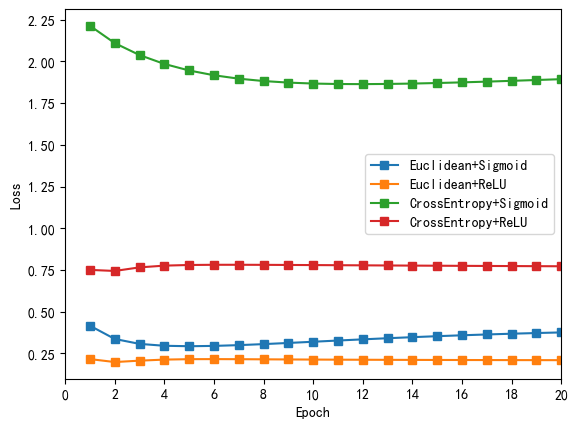

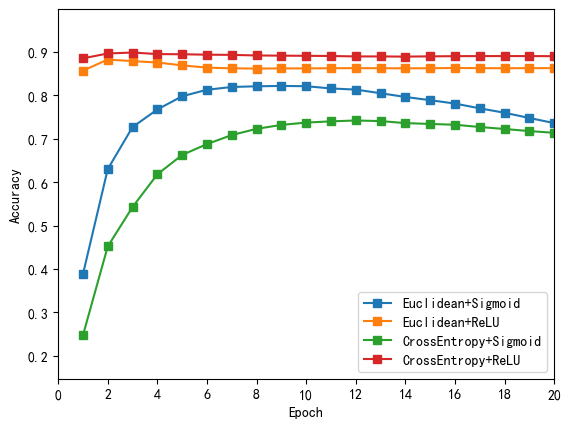

In [8]:
best_index = exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'].idxmax()
euclidean_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'].idxmax()
euclidean_relu= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'].idxmax()
crossEntropy_sigmoid= exec_result.loc[best_index]
best_index = exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'].idxmax()
crossEntropy_relu= exec_result.loc[best_index]
plot_loss_and_acc({'Euclidean+Sigmoid': [euclidean_sigmoid.loss_validate, euclidean_sigmoid.acc_validate],
                   'Euclidean+ReLU': [euclidean_relu.loss_validate, euclidean_relu.acc_validate],
                   'CrossEntropy+Sigmoid': [crossEntropy_sigmoid.loss_validate, crossEntropy_sigmoid.acc_validate],
                   'CrossEntropy+ReLU': [crossEntropy_relu.loss_validate, crossEntropy_relu.acc_validate]})

In [3]:
exec_result.to_csv('./result/result_momentum.csv',index=False)
# euclidean_sigmoid.momentum,euclidean_relu.momentum,crossEntropy_sigmoid.momentum,crossEntropy_relu.momentum
# exec_result=pd.read_csv('./result_momentum.csv')


In [12]:
exec_result

,mode,batch_size,learning_rate_SGD,momentum,weight_decay,time,loss_validate,acc_validate,acc_validate_float
0,Euclidean_Sigmoid,100,0.001,0.00,0.1,42.074909,"[0.5193544682084369, 0.4167396770427404, 0.364...","[0.2218, 0.4354, 0.5536, 0.6236, 0.66980000000...",0.72049
1,Euclidean_ReLU,100,0.001,0.00,0.1,41.935513,"[0.6066053231156066, 0.43967822092945325, 0.36...","[0.4478000000000001, 0.573, 0.6629999999999999...",0.80681
2,CrossEntropy_Sigmoid,100,0.001,0.00,0.1,42.384914,"[2.2419760239290825, 2.120830066790953, 2.0448...","[0.2084, 0.34559999999999996, 0.50940000000000...",0.66653
3,CrossEntropy_ReLU,100,0.001,0.00,0.1,52.771345,"[1.7287515334418808, 1.316340443397868, 1.0911...","[0.5094, 0.7232000000000001, 0.796399999999999...",0.85185
4,Euclidean_Sigmoid,100,0.001,0.10,0.1,43.192641,"[0.46882086734492245, 0.3824436766165054, 0.33...","[0.3148, 0.5144, 0.6312, 0.6958, 0.7334, 0.764...",0.75270
5,Euclidean_ReLU,100,0.001,0.10,0.1,46.562965,"[0.6284309608096394, 0.43873470187546787, 0.35...","[0.39699999999999996, 0.5608, 0.66060000000000...",0.80322
6,CrossEntropy_Sigmoid,100,0.001,0.10,0.1,85.173177,"[2.2142067795608527, 2.110336441159032, 2.0385...","[0.24719999999999998, 0.45199999999999996, 0.5...",0.67096
7,CrossEntropy_ReLU,100,0.001,0.10,0.1,63.942119,"[1.660839475040853, 1.3178145956194982, 1.1201...","[0.54, 0.7057999999999999, 0.7761999999999999,...",0.84501
8,Euclidean_Sigmoid,100,0.001,0.55,0.1,56.571428,"[0.41495263560142653, 0.3354805097896369, 0.30...","[0.38800000000000007, 0.6302, 0.727, 0.7676, 0...",0.76113
9,Euclidean_ReLU,100,0.001,0.55,0.1,86.555884,"[0.42031232663562174, 0.3000379899107795, 0.25...","[0.5559999999999999, 0.7240000000000001, 0.800...",0.84956


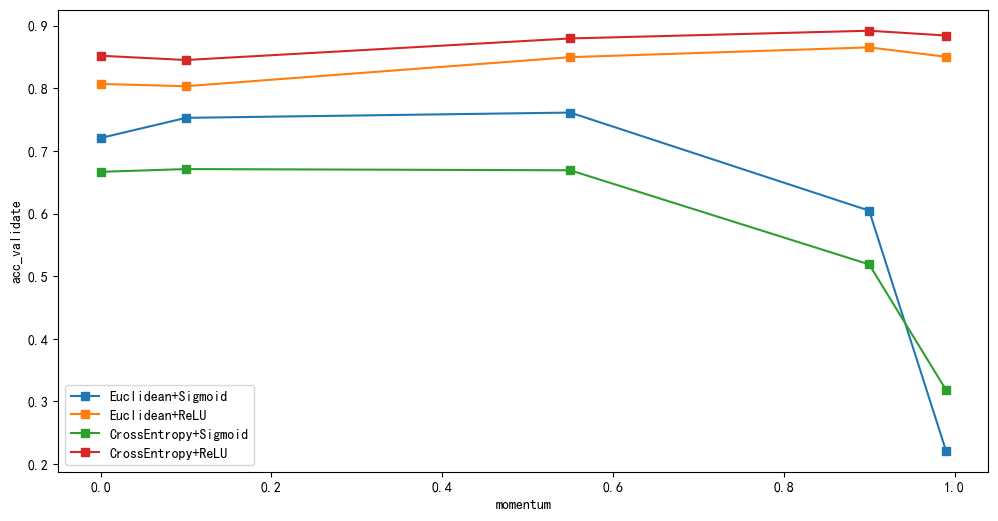

In [6]:
plt.figure(figsize=(12,6), dpi=100)
plt.rcParams['font.sans-serif']=['SimHei']
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['momentum'],exec_result.query("mode == 'Euclidean_Sigmoid'")['acc_validate_float'], marker='s', label = 'Euclidean+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['momentum'],exec_result.query("mode == 'Euclidean_ReLU'")['acc_validate_float'], marker='s', label = 'Euclidean+ReLU')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['momentum'],exec_result.query("mode == 'CrossEntropy_Sigmoid'")['acc_validate_float'], marker='s', label = 'CrossEntropy+Sigmoid')
plt.plot(exec_result.query("mode == 'Euclidean_Sigmoid'")['momentum'],exec_result.query("mode == 'CrossEntropy_ReLU'")['acc_validate_float'], marker='s', label = 'CrossEntropy+ReLU')
plt.xlabel('momentum')
plt.ylabel('acc_validate')
plt.legend()